# 2A.eco - Exercice API SNCF corrigé

Manipulation d'une [API REST](https://fr.wikipedia.org/wiki/Representational_state_transfer), celle de la SNCF est prise comme exemple. Correction d'exercices.

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## Partie 0 - modules recommandés et connexion à l'API 

Il vous faudra sûrement les modules suivant : 

- requests
- datetime
- pandas
- matplotlib

Créer un login pour vous connecter à l'API de la SNCF https://data.sncf.com/api 

Vous pouvez maintenant commencer. Ce notebook peut prendre du temps à s'éxécuter, surout à partir de la partie 3

In [2]:
# !!!!! Attention à bien mettre votre token ici  !!!!!

token_auth = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXX'

In [3]:
import os
from pyquickhelper.loghelper import get_password
if "XXXXXX" in token_auth:
    token_auth = get_password("sncf", "ensae_teaching_cs,key")

## Partie 1 - Trouver les gares accessibles _via_ la SNCF

- Trouver l'ensemble des gares disponibles sur l'API et créer un fichier csv avec les codes de la gare, son nom et ses coordonnées latitude et longitude, ainsi que les informations administratives de la région quand elles sont disponibles

- Représentez les sur un graphique

In [4]:
import pandas as pd
import requests

In [5]:
def page_gares(numero_page) :
    return requests.get(
        ('https://api.sncf.com/v1/coverage/sncf/stop_areas?start_page={}').format(numero_page),
        auth=(token_auth, ''))

######################################
# on commence par la première page qui nous donne le nombre de résultats par page ainsi que le nombre total de résultats                    

page_initiale = page_gares(0)                        
item_per_page = page_initiale.json()['pagination']['items_per_page']
total_items = page_initiale.json()['pagination']['total_result']
dfs = []

# on fait une boucle sur toutes les pages suivantes 
print_done = {}

for page in range(int(total_items/item_per_page)+1) : 
    stations_page = page_gares(page)
    
    ensemble_stations = stations_page.json()
    
    if 'stop_areas' not in ensemble_stations:
        # pas d'arrêt
        continue
    
    # on ne retient que les informations qui nous intéressent 
    for station in ensemble_stations['stop_areas']:

        station['lat'] = station['coord']['lat']
        station["lon"]  = station['coord']['lon']

        if 'administrative_regions' in station.keys() : 
            for var_api, var_df in zip(['insee','name','label','id','zip_code'],
                                       ['insee','region','label_region','id_region','zip_code']): 
                try:
                    station[var_df] = station['administrative_regions'][0][var_api]
                except KeyError:
                    if var_api not in print_done:
                        print("key '{0}' not here but {1}".format(var_api, 
                                ",".join(station['administrative_regions'][0].keys())))
                        print_done[var_api] = var_api

        [station.pop(k,None) for k in ['coord','links','administrative_regions', 'type', 'codes']]

    stations = ensemble_stations['stop_areas']
    try:
        dp = pd.DataFrame(stations)
    except Exception as e:
        # La SNCF modifie parfois le schéma de ses données.
        # On affiche station pour avoir une meilleure idée que l'erreur retournée par pandas
        raise Exception("Problème de données\n{0}".format(stations)) from e
        
    dfs.append(dp)
    if page % 10 == 0:
        print("je suis à la page", page, "---", dp.shape)

import pandas
df = pandas.concat(dfs)
df.to_csv("./ensemble_gares.csv")  
print(df.shape)
df.head()

je suis à la page 0 --- (25, 11)
je suis à la page 10 --- (25, 11)
je suis à la page 20 --- (25, 11)
je suis à la page 30 --- (25, 11)
je suis à la page 40 --- (25, 11)
je suis à la page 50 --- (25, 11)
je suis à la page 60 --- (25, 11)
je suis à la page 70 --- (25, 11)
je suis à la page 80 --- (25, 11)
je suis à la page 90 --- (25, 11)
je suis à la page 100 --- (25, 11)
je suis à la page 110 --- (25, 11)
je suis à la page 120 --- (25, 11)
je suis à la page 130 --- (25, 11)
je suis à la page 140 --- (25, 11)
je suis à la page 150 --- (25, 11)
je suis à la page 160 --- (25, 11)
je suis à la page 170 --- (25, 11)
je suis à la page 180 --- (25, 11)
je suis à la page 190 --- (25, 11)
(4920, 11)


,name,label,timezone,id,lat,lon,insee,region,label_region,id_region,zip_code
0,,,Europe/Paris,stop_area:SNCF:87407536,0,0,NaN,NaN,NaN,NaN,NaN
1,Abancourt,Abancourt (Abancourt),Europe/Paris,stop_area:SNCF:87313759,49.685621,1.774297,60001,Abancourt,Abancourt (60220),admin:fr:60001,60220
2,Abbaretz,Abbaretz (Abbaretz),Europe/Paris,stop_area:SNCF:87481614,47.555241,-1.524289,44001,Abbaretz,Abbaretz (44170),admin:fr:44001,44170
3,Abbeville,Abbeville (Abbeville),Europe/Paris,stop_area:SNCF:87317362,50.102175,1.824538,80001,Abbeville,Abbeville (80100),admin:fr:80001,80100
4,Ablon,Ablon (Ablon-sur-Seine),Europe/Paris,stop_area:SNCF:87545269,48.725443,2.419213,94001,Ablon-sur-Seine,Ablon-sur-Seine (94480),admin:fr:94001,94480


In [6]:
df[df.name.str.contains('Lyon')]

,name,label,timezone,id,lat,lon,insee,region,label_region,id_region,zip_code
19,Gare De Lyon Noctilien,Gare De Lyon Noctilien (Paris),Europe/Paris,stop_area:SNCF:87588202,48.84578,2.373719,75056,Paris,Paris (75000-75116),admin:fr:75056,75000;75116
2,Lyon Gorge de Loup,Lyon Gorge de Loup (Lyon),Europe/Paris,stop_area:SNCF:87721175,45.766095,4.804697,69123,Lyon,Lyon,admin:fr:69123,
3,Lyon Jean Macé,Lyon Jean Macé (Lyon),Europe/Paris,stop_area:SNCF:87282624,45.74503,4.841499,69123,Lyon,Lyon,admin:fr:69123,
4,Lyon Part Dieu,Lyon Part Dieu (Lyon),Europe/Paris,stop_area:SNCF:87723197,45.760596,4.859409,69123,Lyon,Lyon,admin:fr:69123,
5,Lyon Perrache,Lyon Perrache (Lyon),Europe/Paris,stop_area:SNCF:87722025,45.748508,4.825777,69123,Lyon,Lyon,admin:fr:69123,
6,Lyon Saint-Exupéry TGV,Lyon Saint-Exupéry TGV (Colombier-Saugnieu),Europe/Paris,stop_area:SNCF:87762906,45.721109,5.074969,69299,Colombier-Saugnieu,Colombier-Saugnieu (69124-69125),admin:fr:69299,69124;69125
7,Lyon Saint-Paul,Lyon Saint-Paul (Lyon),Europe/Paris,stop_area:SNCF:87721159,45.766077,4.826954,69123,Lyon,Lyon,admin:fr:69123,
8,Lyon Vaise,Lyon Vaise (Lyon),Europe/Paris,stop_area:SNCF:87721001,45.77976,4.804186,69123,Lyon,Lyon,admin:fr:69123,
9,Lyon-Part-Dieu Gare Routière,Lyon-Part-Dieu Gare Routière (Lyon),Europe/Paris,stop_area:SNCF:87697128,45.761064,4.862984,69123,Lyon,Lyon,admin:fr:69123,
10,Lyon-Perrache Gare Routière,Lyon-Perrache Gare Routière (Lyon),Europe/Paris,stop_area:SNCF:87697136,45.74912,4.827332,69123,Lyon,Lyon,admin:fr:69123,


In [7]:
df = pd.read_csv("./ensemble_gares.csv", encoding = "ISO-8859-1")
print(df.columns)
print(df.shape)
# Exemple des informations sur une gare
df.iloc[317]

Index(['Unnamed: 0', 'name', 'label', 'timezone', 'id', 'lat', 'lon', 'insee',
       'region', 'label_region', 'id_region', 'zip_code'],
      dtype='object')
(4920, 12)


Unnamed: 0                           17
name                             Bandol
label                   Bandol (Bandol)
timezone                   Europe/Paris
id              stop_area:SNCF:87755223
lat                           43.140385
lon                            5.750128
insee                           83009.0
region                           Bandol
label_region             Bandol (83150)
id_region                admin:fr:83009
zip_code                          83150
Name: 317, dtype: object

In [8]:
# on crée un dictionnaire des correspondances entre les noms et les codes des gares
dict_label_gare_code = df[['label','id']].set_index('label').to_dict()['id']
dict_nom_gare_code = df[['name','id']].set_index('name').to_dict()['id']

Index(['Unnamed: 0', 'name', 'label', 'timezone', 'id', 'lat', 'lon', 'insee',
       'region', 'label_region', 'id_region', 'zip_code'],
      dtype='object')


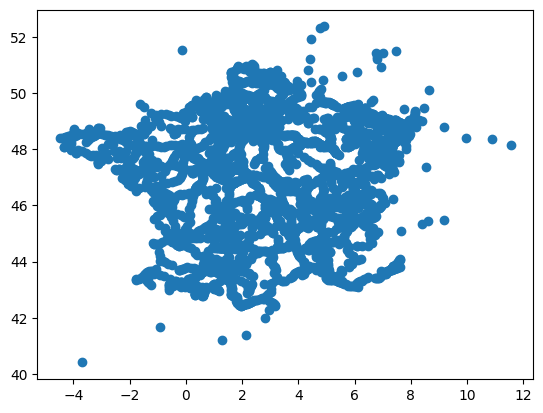

In [9]:
print(df.columns)

# graphique dans le plan des gares
%matplotlib inline
import matplotlib.pyplot as plt
lng_var = df[(df['lat']>35) & (df['lat']<60)]["lon"].tolist()
lat_var = df[(df['lat']>35) & (df['lat']<60)]["lat"].tolist()
plt.scatter(x = lng_var , y = lat_var,marker = "o");

## Les trajets depuis la Gare de Lyon

### Partons à Lyon

Imaginez que vous vouliez un peu voyager hors de Paris, et il se trouve que justement on vous propose de passer quelques jours à Lyon. Vous partez le 17 novembre vers 19h50 pour ne pas trop écourter votre journée de travail ([documentation de l'API](https://doc.navitia.io/#api-catalog)).

#### Question 1

- Commencez par récupérer les informations sur le trajet entre Paris Gare de Lyon et Lyon Perrache le 17 novembre à 19h57

    - Paris - Gare de Lyon (code de la gare : __stop\_area:SNCF:87686006__)

    - Lyon - Gare Lyon Perrache (code de la gare : __stop\_area:SNCF:87722025__)
    
    - Indice : utiliser la requête "journeys"
    
    - Autre indice : le format de la date est AAAAMMJJTHHMMSS (Année, mois, jour, heure, minutes, secondes)
    
- Répondez aux questions suivantes 
    - combien y a-t-il d'arrêts entre ces deux gares ? (utilisez la clé 'journeys')
    - combien de temps d'arrêt à chacune d'elles ?

Tout d'abord une fonction qui sera utile pour calculer des temps :

In [10]:
from datetime import datetime, timedelta

def convertir_en_temps(chaine) : 
    ''' on convertit en date la chaine de caractères de l API'''
    return datetime.strptime(chaine.replace('T',''),'%Y%m%d%H%M%S')

Et l'inverse :

In [11]:
def convertir_en_chaine(dt) : 
    ''' on convertit en chaîne de caractères un datetime'''
    return datetime.strftime(dt, '%Y%m%dT%H%M%S')

now = datetime.now()
convertir_en_chaine(now)

'20221207T110203'

In [12]:
convertir_en_temps(convertir_en_chaine(now))

datetime.datetime(2022, 12, 7, 11, 2, 3)

In [19]:
# informations sur le trajet qu'on choisit dans le futur
# l'API ne retourne pas de résultatq très loin dans le passé
now = datetime.now()
dt = now + timedelta(14)  # dans deux semaines

date_depart = convertir_en_chaine(dt)
gare_depart = 'stop_area:SNCF:87686006'
gare_arrivee = 'stop_area:SNCF:87722025'

date_depart

'20221221T112354'

Ensemble des départs :

In [20]:
paris_lyon = requests.get(
    ('https://api.sncf.com/v1/coverage/sncf/journeys?'
     'from={}&to={}&datetime={}').format(gare_depart, gare_arrivee, date_depart),
    auth=(token_auth, '')).json()

Les gares du chemin entre Paris et Lyon sur ce trajet ainsi que le temps d'arrêt :

In [23]:
session = paris_lyon['journeys'][0]['sections'][1]
rows = []
if "stop_date_times" in session:
    for i in session['stop_date_times']:
        rows.append(dict(name=i['stop_point']['name'],
                         depart=convertir_en_temps(i['departure_date_time']),
                         arrivee=convertir_en_temps(i['arrival_date_time'])))
pandas.DataFrame(rows)
# debug

,name,depart,arrivee
0,Paris Gare de Lyon Hall 1 &2,2022-12-21 11:48:00,2022-12-21 11:48:00
1,Le Creusot-TGV,2022-12-21 13:17:00,2022-12-21 13:14:00
2,Lyon Part Dieu,2022-12-21 14:02:00,2022-12-21 13:56:00
3,Lyon Perrache,2022-12-21 14:10:00,2022-12-21 14:10:00


#### Question 2

Vous êtes un peu pressé et vous avez peur de vous tromper en arrivant à la gare car d'autres TGV partent à peu près en même temps (à partir de 19h00) de la gare de Lyon. Si vous demandez à l'API, combien de résultats vous donne-t-elle ?

Soit l'API a changé, soit...

In [86]:
requests.get(
    ('https://api.sncf.com/v1/coverage/sncf/stop_areas/'
     'stop_area:SNCF:87686006/departures'), auth=(token_auth, '')).json()

{'pagination': {'start_page': 0,
  'items_on_page': 10,
  'items_per_page': 10,
  'total_result': 10},
 'links': [{'href': 'https://api.sncf.com/v1/coverage/sncf/stop_points/{stop_point.id}',
   'type': 'stop_point',
   'rel': 'stop_points',
   'templated': True},
  {'href': 'https://api.sncf.com/v1/coverage/sncf/commercial_modes/{commercial_modes.id}',
   'type': 'commercial_modes',
   'rel': 'commercial_modes',
   'templated': True},
  {'href': 'https://api.sncf.com/v1/coverage/sncf/stop_areas/{stop_area.id}',
   'type': 'stop_area',
   'rel': 'stop_areas',
   'templated': True},
  {'href': 'https://api.sncf.com/v1/coverage/sncf/physical_modes/{physical_modes.id}',
   'type': 'physical_modes',
   'rel': 'physical_modes',
   'templated': True},
  {'href': 'https://api.sncf.com/v1/coverage/sncf/routes/{route.id}',
   'type': 'route',
   'rel': 'routes',
   'templated': True},
  {'href': 'https://api.sncf.com/v1/coverage/sncf/commercial_modes/{commercial_mode.id}',
   'type': 'commercia

In [96]:
### les trains qui partent autour de 19h00
departs_paris = requests.get(
    ('https://api.sncf.com/v1/coverage/sncf/stop_areas/stop_area:SNCF:'
     '87686006/departures?from_datetime={}').format(
        date_depart), auth=(token_auth, '')).json()

# Nombre de trains que l'API renvoie à partir de cet horaire-là
#print(len(departs_paris['departures']))
departs_paris

{'pagination': {'start_page': 0,
  'items_on_page': 10,
  'items_per_page': 10,
  'total_result': 10},
 'links': [{'href': 'https://api.sncf.com/v1/coverage/sncf/stop_points/{stop_point.id}',
   'type': 'stop_point',
   'rel': 'stop_points',
   'templated': True},
  {'href': 'https://api.sncf.com/v1/coverage/sncf/commercial_modes/{commercial_modes.id}',
   'type': 'commercial_modes',
   'rel': 'commercial_modes',
   'templated': True},
  {'href': 'https://api.sncf.com/v1/coverage/sncf/stop_areas/{stop_area.id}',
   'type': 'stop_area',
   'rel': 'stop_areas',
   'templated': True},
  {'href': 'https://api.sncf.com/v1/coverage/sncf/physical_modes/{physical_modes.id}',
   'type': 'physical_modes',
   'rel': 'physical_modes',
   'templated': True},
  {'href': 'https://api.sncf.com/v1/coverage/sncf/routes/{route.id}',
   'type': 'route',
   'rel': 'routes',
   'templated': True},
  {'href': 'https://api.sncf.com/v1/coverage/sncf/commercial_modes/{commercial_mode.id}',
   'type': 'commercia

In [89]:
from jyquickhelper import JSONJS
JSONJS(departs_paris)

- Quels sont les horaires de départ de ces trains ? 

In [90]:
for i in range(len(departs_paris['departures'])) :
    print(departs_paris['departures'][i]['stop_date_time']['departure_date_time'])

20221221T113300
20221221T114300
20221221T114800
20221221T115400
20221221T120800
20221221T120800
20221221T121400
20221221T121900
20221221T122300
20221221T122800


- Parmi ces trains, combien de trains ont pour destination finale Lyon et qui partent le 17 novembre ?

In [108]:
nombre_trains_pour_lyon = 0

for depart in departs_paris['departures'] :     
    if "Lyon" in depart['display_informations']['direction']:
        if (convertir_en_temps(depart['stop_date_time']['arrival_date_time']) > 
                convertir_en_temps(date_depart) and
                convertir_en_temps(depart['stop_date_time']['arrival_date_time']) < 
                datetime(2022,12,31,0,0,0)):
            nombre_trains_pour_lyon += 1
            print("le prochain départ pour Lyon sera le",
                  convertir_en_temps(depart['stop_date_time']['arrival_date_time']))
        
print("Il y a" , nombre_trains_pour_lyon, "train(s) pour Lyon dans les trains proposés", 
      "par l'API qui partent encore le 17 novembre")

le prochain départ pour Lyon sera le 2022-12-21 11:48:00
le prochain départ pour Lyon sera le 2022-12-21 12:23:00
Il y a 2 train(s) pour Lyon dans les trains proposés par l'API qui partent encore le 17 novembre


### C'est quand qu'on va où ?

En fait, vous n'êtes plus très sûr de vouloir aller à Lyon. Mais bon maintenant vous êtes Gare de Lyon et il est 18h00. 

#### Question 3

- Combien de tgv partent entre 18h00 et 20h00 ?
- Lequel arrive le plus tôt à sa destination finale ?

In [99]:
# on crée deux fonctions : 

def trouver_destination_tgv(origine, datetime) : 
    '''Permet d avoir les 10 prochains départs d une gare donnée '''
    return requests.get('https://api.sncf.com/v1/coverage/sncf/stop_areas/{}/' \
                        'departures?from_datetime={}'.format(origine, datetime) ,
                        auth=(token_auth, '')).json()

def trouver_trajet_dispo_max_heure(gare_depart, date_heure_depart, date_heure_max) : 
    '''Permet d avoir toutes les informations sur des trajets partant 
    d une gare entre une date X et une date Y'''
    
    destinations = []
    
    # on interroge l'API tant qu'il renvoie des information
    # sur les trains partant de Gare de lyon 

    while convertir_en_temps(date_heure_depart) < convertir_en_temps(date_heure_max) :
    # on prend toutes les destinations qui partent à partir d'une certaine heure
        destinations = destinations + trouver_destination_tgv(
            gare_depart, date_heure_depart)['departures']
        
        nombre_resultats = trouver_destination_tgv(
            gare_depart, date_heure_depart)['pagination']['items_on_page']
        
        if nombre_resultats <= 0:
            break

        # on trouve l'heure max de la première série de 10 solutions que l'application renvoie
        # on remplace l'heure qu'on cherche par celle là
        resultats = trouver_destination_tgv(gare_depart, date_heure_depart)
        date_heure_depart = resultats['departures'][nombre_resultats-1][
            'stop_date_time']['departure_date_time']

    return destinations

In [105]:
# on trouve l'ensemble des trajets dont le départ est compris entre deux horaires
# informations sur le trajet qu'on choisit dans le futur
# l'API ne retourne pas de résultatq très loin dans le passé
now = datetime.now()
if now.hour < 6:
    # pas trop tôt
    now += timedelta(hours=4)
dt = now + timedelta(14)  # dans deux semaines

date_heure = convertir_en_chaine(dt)
max_date_heure = convertir_en_chaine(dt + timedelta(hours=24))
print("entre", date_heure, "et", max_date_heure)

gare_initiale = 'stop_area:SNCF:87686006'

# on demande à avoir tous les trajets partant de gare de lyon
# entre deux heures précises

destinations_depuis_paris_max_20h = trouver_trajet_dispo_max_heure(
    gare_initiale, date_heure, max_date_heure)

# on veut supprimer ceux pour lesquels le départ est après 20h00

dictionnaire_destinations = {}

i = 0

for depart in destinations_depuis_paris_max_20h :    
    print(depart['display_informations']['direction'],
          depart['stop_date_time']['departure_date_time'])
    if (convertir_en_temps(depart['stop_date_time']['departure_date_time']) < 
            convertir_en_temps(max_date_heure)): 
        i += 1
        dictionnaire_destinations[i] = depart 
    
print("Je peux prendre", len(dictionnaire_destinations.keys()), 
      "trains qui partent entre 18h et 20h de Gare de Lyon")

entre 20221221T121515 et 20221222T121515
Zuerich HB (Zürich) 20221221T121900
Lyon Perrache (Lyon) 20221221T122300
Marseille Saint-Charles (Marseille) 20221221T122800
Annecy (Annecy) 20221221T123800
Lyon Perrache (Lyon) 20221221T124200
Saint-Étienne Châteaucreux (Saint-Étienne) 20221221T124200
Laroche - Migennes (Migennes) 20221221T124600
Lyon Perrache (Lyon) 20221221T134100
Nice-Ville (Nice) 20221221T134900
Grenoble (Grenoble) 20221221T135500
Grenoble (Grenoble) 20221221T135500
Lausanne (Lausanne) 20221221T141000
Basel SBB (Basel) 20221221T141500
Montpellier Saint-Roch (Montpellier) 20221221T143400
Marseille Saint-Charles (Marseille) 20221221T143900
MILANO PORTA GARIBALDI (Milano) 20221221T144500
Laroche - Migennes (Migennes) 20221221T144600
Besançon Viotte (Besançon) 20221221T144900
Barcelone-Sants (Barcelona) 20221221T145400
Lyon Perrache (Lyon) 20221221T145900
Lyon Perrache (Lyon) 20221221T145900
Marseille Saint-Charles (Marseille) 20221221T153800
Lyon Perrache (Lyon) 20221221T15490

In [107]:
dictionnaire_destinations

{1: {'display_informations': {'direction': 'Zuerich HB (Zürich)',
   'code': '',
   'network': 'TGV Lyria',
   'links': [],
   'color': '',
   'name': 'Paris Gare de Lyon Hall 1 &2 - Zuerich HB',
   'physical_mode': 'Train grande vitesse',
   'headsign': '9213',
   'label': 'Paris Gare de Lyon Hall 1 &2 - Zuerich HB',
   'equipments': [],
   'text_color': '',
   'trip_short_name': '9213',
   'commercial_mode': 'TGV Lyria',
   'description': ''},
  'stop_point': {'commercial_modes': [{'id': 'commercial_mode:ELI',
     'name': 'RENFE SNCF'},
    {'id': 'commercial_mode:LYR', 'name': 'TGV Lyria'},
    {'id': 'commercial_mode:OUI', 'name': 'TGV INOUI'},
    {'id': 'commercial_mode:OUIGO_TC', 'name': 'OUIGO Train Classique'},
    {'id': 'commercial_mode:SNF', 'name': 'SNCF'},
    {'id': 'commercial_mode:TER', 'name': 'TER'},
    {'id': 'commercial_mode:TGVOUIGO', 'name': 'OUIGO'}],
   'name': 'Paris Gare de Lyon Hall 1 &2',
   'links': [],
   'physical_modes': [{'co2_emission_rate': {'value

### Et les correspondances ? 

#### Question 4

- On va essayer de voir jusqu'où on peut aller, en prenant des trains au départ de la Gare de Lyon : 
    - Quelles sont toutes les gares atteignables en partant le 17 novembre, sans faire de changement et sans partir après minuit ?
    - Si on prend un de ces trains, jusqu'où peut-on aller, avec une correspondance, sans partir après 8h le lendemain matin ?

In [112]:
# on va trouver toutes les gares qui sont sur les trajets des 
# trains retenus donc atteignables sans correspondance

def trouver_toutes_les_gares_du_trajet(gare_depart, gare_arrivee_finale, horaire_depart) :
    return requests.get('https://api.sncf.com/v1/coverage/sncf/journeys?from={}&to={}' \
                        '&datetime={}'.format(gare_depart,gare_arrivee_finale,horaire_depart), \
                        auth=(token_auth, '')).json()

In [113]:
# Exemple pour la première gare de la liste

if len(dictionnaire_destinations) > 1:
    gare_depart = dictionnaire_destinations[1]['stop_point']['id']
    gare_arrivee = dictionnaire_destinations[1]['route']['direction']['id']
    horaire_train = dictionnaire_destinations[1]['stop_date_time']['arrival_date_time']

    trajet_recherche = trouver_toutes_les_gares_du_trajet(gare_depart,gare_arrivee,horaire_train)
    session = trajet_recherche['journeys'][0]['sections'][0]
    if "stop_date_times" in session:
        for i in session['stop_date_times']:
            print(i['stop_point']['name'])

In [114]:
# on fait la liste des gares où on
# peut aller sans correspondance

liste_gares_direct = []

for x in dictionnaire_destinations.keys():
    # on prend les deux gares départ + finale
    gare_depart = dictionnaire_destinations[x]['stop_point']['id']
    gare_arrivee = dictionnaire_destinations[x]['route']['direction']['id']
    horaire_train = dictionnaire_destinations[x]['stop_date_time']['arrival_date_time']
    
    # on appelle la fonction définie précédemment
    trajet_recherche = trouver_toutes_les_gares_du_trajet(gare_depart,gare_arrivee,horaire_train)
    if 'error' in trajet_recherche:
        continue
    session = trajet_recherche['journeys'][0]['sections'][0]
    if "stop_date_times" in session:
        for i in session['stop_date_times']: 
            print(i['stop_point']['name'], i['arrival_date_time'])
            liste_gares_direct.append(i['stop_point']['name'])
        print("-------------")    
    
#### là on a la liste des gares atteignables sans correspondance    
liste_gares_direct = set(liste_gares_direct)

Paris Gare de Lyon Hall 1 &2 20221221T134900
Marseille Saint-Charles 20221221T171400
-------------
Paris Gare de Lyon Hall 1 &2 20221221T123800
Mâcon - Loché TGV 20221221T142000
Chambéry - Challes-les-Eaux 20221221T153600
Aix-les-Bains le Revard 20221221T155930
Annecy 20221221T163230
-------------
Paris Gare de Lyon Hall 1 &2 20221221T124600
Melun 20221221T131200
Bois-le-Roi 20221221T131830
Fontainebleau - Avon 20221221T132530
Moret - Veneux-les-Sablons 20221221T133200
Saint-Mammès 20221221T133500
Montereau 20221221T134330
Villeneuve-la-Guyard 20221221T135330
Champigny 20221221T135930
Pont-sur-Yonne 20221221T140630
Sens 20221221T141600
-------------
Paris Gare de Lyon Hall 1 &2 20221221T134900
Marseille Saint-Charles 20221221T171400
Toulon 20221221T181100
Saint-Raphaël Valescure 20221221T190100
Cannes 20221221T192600
Antibes 20221221T193900
Nice-Ville 20221221T195800
-------------
Paris Gare de Lyon Hall 1 &2 20221221T135500
Lyon Saint-Exupéry TGV 20221221T155500
Grenoble 20221221T1713

Paris Gare de Lyon Hall 1 &2 20221222T120800
Lyon Saint-Exupéry TGV 20221222T140500
Grenoble 20221222T151300
-------------


#### Exemple : trouver toutes les correspondances possibles depuis le trajet entre les gares de Paris et de Perpignan

In [115]:
# pour le premier trajet gare de la liste trouvée à l'étape précédente
# on va chercher toutes les connexions des gares possibles, entre le moment de l'arrivée 
# et 8 heures le lendemain matin

if len(dictionnaire_destinations) > 1:
    gare_depart = dictionnaire_destinations[1]['stop_point']['id']
    gare_arrivee = dictionnaire_destinations[1]['route']['direction']['id']
    horaire_train = dictionnaire_destinations[1]['stop_date_time']['arrival_date_time']

    horaire_max = convertir_en_chaine(dt + timedelta(hours=8))
    print("horaire_max", horaire_max)
else:
    horaire_train = None

horaire_max 20221221T201515


In [117]:
trajet_recherche['journeys'][0]['sections'][0]

{'from': {'embedded_type': 'stop_point',
  'stop_point': {'name': 'Paris Gare de Lyon Hall 1 &2',
   'links': [],
   'coord': {'lat': '48.844945', 'lon': '2.373481'},
   'label': 'Paris Gare de Lyon Hall 1 &2 (Paris)',
   'equipments': [],
   'administrative_regions': [{'insee': '75056',
     'name': 'Paris',
     'level': 8,
     'coord': {'lat': '48.8534951', 'lon': '2.3483915'},
     'label': 'Paris (75000-75116)',
     'id': 'admin:fr:75056',
     'zip_code': '75000;75116'}],
   'id': 'stop_point:SNCF:87686006:LongDistanceTrain',
   'stop_area': {'codes': [{'type': 'secondary_id', 'value': 'SNCF:87686030'},
     {'type': 'secondary_id', 'value': 'SNCF:87758581'},
     {'type': 'source', 'value': '87686006'},
     {'type': 'source', 'value': '87686030'},
     {'type': 'source', 'value': '87758581'},
     {'type': 'uic', 'value': '87686006'},
     {'type': 'uic', 'value': '87686030'},
     {'type': 'uic', 'value': '87758581'}],
    'name': 'Paris Gare de Lyon Hall 1 &2',
    'links':

#### Question 5
- Représenter toutes les gares atteignables avec un graphique de type scatter. Distinguer les gares atteintes en un seul trajet et celles atteintes avec une correspondance.

In [127]:
# on va les représenter grâce à la base des latitude / longitude

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D 

mpl.rcParams['axes.facecolor'] = "whitesmoke"

palette = plt.cm.spring 

liste_couleurs = [palette(0), palette(0.5), palette(0.8)]

data_all = pd.read_csv("./ensemble_gares.csv", encoding = "ISO-8859-1")

connexions = []
lat = []
lon = []
labels = []

dict_lat = data_all.set_index('name')['lat'].to_dict()
dict_lon = data_all.set_index('name')['lon'].to_dict()
#dict_lab = data_all.set_index('name')['name'].str.replace("gare de","").to_dict()


for gare in dict_type_gares: 
    if gare not in dict_lat:
        print("'{0}' pas trouvé dans dict_lat (problème d'accents?)".format(gare))
        continue
    if gare not in dict_lon:
        print("'{0}' pas trouvé dans dict_lon (problème d'accents?)".format(gare))
        continue
    lat.append(dict_lat[gare])                              
    lon.append(dict_lon[gare])
    labels.append(gare)

'Mâcon - Loché TGV' pas trouvé dans dict_lat (problème d'accents?)
'Besançon Franche-Comté TGV' pas trouvé dans dict_lat (problème d'accents?)
'Valence TGV Rhône-Alpes Sud' pas trouvé dans dict_lat (problème d'accents?)
'Chambéry - Challes-les-Eaux' pas trouvé dans dict_lat (problème d'accents?)
'Nîmes Pont du Gard' pas trouvé dans dict_lat (problème d'accents?)
'Saint-Mammès' pas trouvé dans dict_lat (problème d'accents?)
'Besançon Viotte' pas trouvé dans dict_lat (problème d'accents?)
'Étigny - Véron' pas trouvé dans dict_lat (problème d'accents?)
'Saint-Raphaël Valescure' pas trouvé dans dict_lat (problème d'accents?)
'Lyon Saint-Exupéry TGV' pas trouvé dans dict_lat (problème d'accents?)
'Béziers' pas trouvé dans dict_lat (problème d'accents?)
'Nîmes Centre' pas trouvé dans dict_lat (problème d'accents?)
'Sète' pas trouvé dans dict_lat (problème d'accents?)


In [128]:
%matplotlib inline

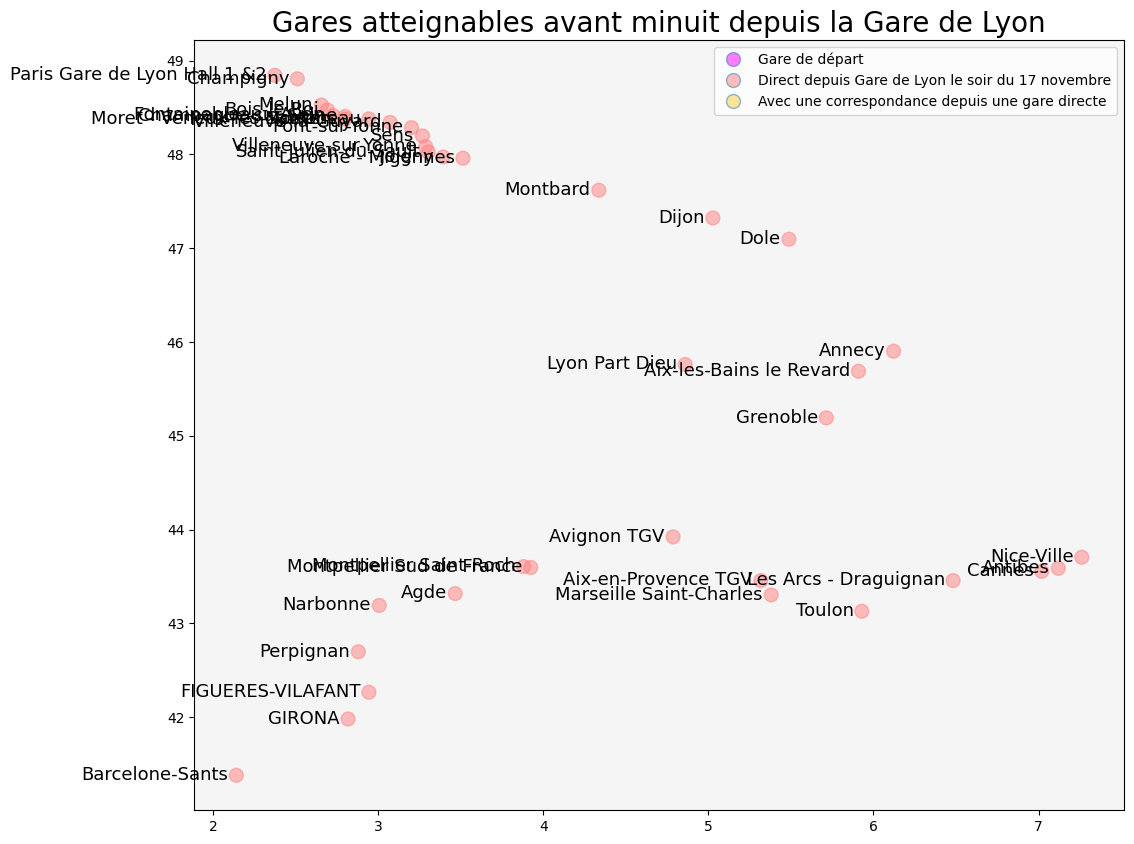

In [129]:
### La carte 
###################################################################################################

def liste_unique(liste) : 
    unicite = [] 
    for x in liste : 
        if x in unicite :
            pass
        else :
            unicite.append(x)
    return unicite

lab_un = liste_unique(labels)
lat_un = liste_unique(lat)
lon_un = liste_unique(lon)

fig = plt.figure(figsize=(12,10))

for label, x, y in set(zip(labels, lon, lat)) :
    if dict_type_gares[label] == "direct" :  
        plt.annotate(label, xy = (x - 0.05, y - 0.05), horizontalalignment = 'right', size = 13)
    else :
        plt.annotate(label, xy = (x + 0.05, y + 0.05), horizontalalignment = 'left', size = 13)

colors = []     
for x in lab_un : 
    if dict_type_gares[x] == "depart" : 
        colors.append(liste_couleurs[0])
    if dict_type_gares[x] == "direct" :
        colors.append(liste_couleurs[1])
    if dict_type_gares[x] == "correspondance" : 
        colors.append(liste_couleurs[2])
                
        
plt.scatter(x = lon_un , y = lat_un, marker = "o", c = colors, s = 100, alpha = 0.5)

#### Legende

circ1 = Line2D([0], [0], linestyle="none", marker="o", alpha=0.5, markersize=10, markerfacecolor = liste_couleurs[0])
circ2 = Line2D([0], [0], linestyle="none", marker="o", alpha=0.5, markersize=10, markerfacecolor = liste_couleurs[1])
circ3 = Line2D([0], [0], linestyle="none", marker="o", alpha=0.5, markersize=10, markerfacecolor = liste_couleurs[2])

legende = plt.legend((circ1, circ2, circ3), ("Gare de départ", "Direct depuis Gare de Lyon le soir du 17 novembre", 
                                             "Avec une correspondance depuis une gare directe"), numpoints=1, loc="best")

legende.get_frame().set_facecolor('white')

plt.title("Gares atteignables avant minuit depuis la Gare de Lyon", size = 20);